In [1]:
%matplotlib inline

In [2]:
# HACK: needed to manually import sys.path from ipython repl, for some reason it doesn't work on my host otherwise
import sys
sys.path = ['', '/Users/naveed/scratch/fraud_detection_project/venv/bin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python27.zip', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-darwin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-tk', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-old', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-dynload', '/Users/naveed/anaconda2/lib/python2.7', '/Users/naveed/anaconda2/lib/python2.7/plat-darwin', '/Users/naveed/anaconda2/lib/python2.7/lib-tk', '/Users/naveed/anaconda2/lib/python2.7/plat-mac', '/Users/naveed/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/IPython/extensions', '/Users/naveed/.ipython']

In [98]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.set_option('max_colwidth', -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import xgboost

In [5]:
pdf = pd.read_csv('./creditcard.csv')

# Notes:
 - Reduced FeatureSet: 28 Features determined from prior PCA analysis. Original features were scrubbed for user anonymity
 - Time & Amount are the only two original features
 - Total Samples in DataSet: 284,807. Number of Fraudalent transactions: 492 (0.172%) of all transactions. Represented by "Class" Feature
 
# Goal:
 - with the highly imbalanced data set, normalize the data by normalizing  underfitting the data
 - compare different models and estimate which ones perform better
 - go back and use some oversampling method to see how the models change with the availability of more data
 - 

In [6]:
numerical_features_only = sorted(list(set(pdf.columns.tolist()) - set(['Time', 'Amount', 'Class'])), key=lambda x: int(x[1:]))

## Fraud Class EDA

In [7]:
fraud_df = pdf.loc[pdf.Class == 1]

In [8]:
fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


## Notes:
- using just the numerical variables, it seems that positive correlations exist between (8x9, 15-17), neg corr: (1-3, 18x15-17)

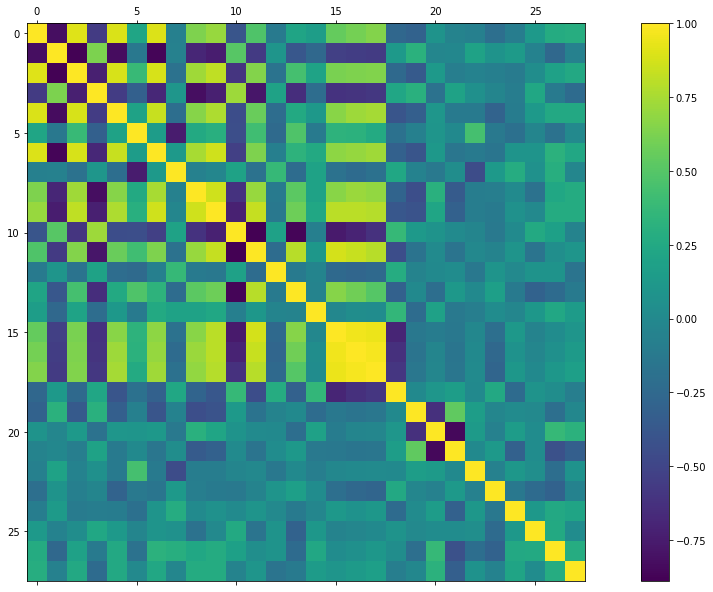

In [99]:
fig = plt.figure(figsize=(20,10))
cax = plt.matshow(fraud_df[numerical_features_only].corr(), fignum=1)
fig.colorbar(cax)

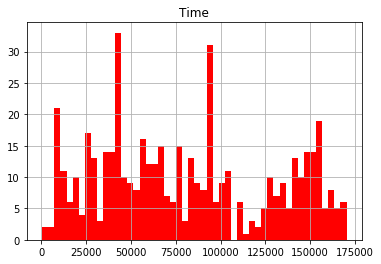

In [101]:
y = fraud_df[['Time']].hist(bins=50, color='red')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1199d2c50>]],
      dtype=object)

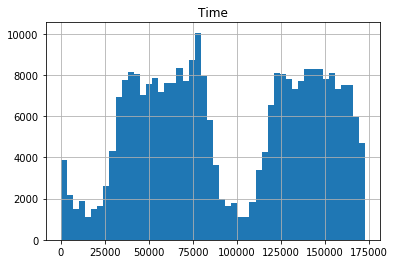

In [102]:
pdf[['Time']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a550210>]],
      dtype=object)

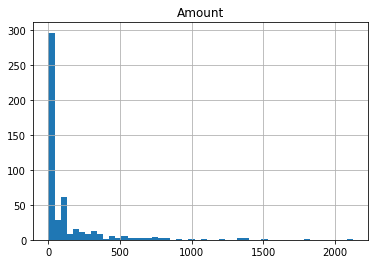

In [103]:
fraud_df[['Amount']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11abe3890>]],
      dtype=object)

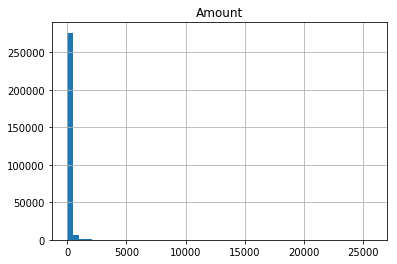

In [104]:
pdf[['Amount']].hist(bins=50)

## Data Preparation
- Dealing with imbalanced data seems to be a concern here because of the disparity of fraudalent data
    - Oversampling — SMOTE
    - Undersampling — RandomUnderSampler
    - Combined Class Methods — SMOTE + ENN
- Outlier Detection & Removal
- Dimensionality Reduction

In [105]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

pdf['time_normalized'] = normalize(pdf.Time)
pdf['amount_normalized'] = normalize(pdf.Amount)

In [15]:
def undersample(df):
    discriminant_feature = df.loc[df.Class == 1]
    cnt = len(discriminant_feature)
    other_set = df.loc[df.Class == 0].sample(n=cnt)
    
    together = pd.concat([discriminant_feature,other_set])
    return together.sample(frac=1)
    

balanced_df = undersample(pdf[numerical_features_only + ['time_normalized', 'amount_normalized', 'Class']])

In [16]:
features = [x for x in balanced_df.columns.tolist() if x != 'Class']

X = balanced_df[features]
y = balanced_df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [17]:
results = pd.DataFrame()

## ML Models to try out
- [**DONE**] Logistic Regression
- [**DONE**] Linear Discriminant Analysis
- [**DONE**] K Nearest Neighbors (KNN)
- [**DONE**] Classification Trees (Decision Tree, Random Forest)
- [**DONE**]Support Vector Classifier
- [**DONE**] Random Forest Classifier
- [**DONE**] XGBoost Classifier (could not get this thing to compile -- try again later)

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


#### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [20]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[368  17]
 [ 34 369]]


In [21]:
print(classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud']))
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)

              precision    recall  f1-score   support

   not_fraud       0.92      0.96      0.94       385
       fraud       0.96      0.92      0.94       403

   micro avg       0.94      0.94      0.94       788
   macro avg       0.94      0.94      0.94       788
weighted avg       0.94      0.94      0.94       788



In [22]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'logistic_regression',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.9351969504447267, 'not_fraud_precision': 0.9154228855721394, 'not_fraud_recall': 0.9558441558441558, 'fraud_recall': 0.9156327543424317, 'fraud_precision': 0.9559585492227979, 'fraud_f1-score': 0.9353612167300379}


In [23]:
data

{'false_negative': 17,
 'false_positive': 34,
 'fraud_f1-score': 0.9353612167300379,
 'fraud_precision': 0.9559585492227979,
 'fraud_recall': 0.9156327543424317,
 'name': 'logistic_regression',
 'not_fraud_f1-score': 0.9351969504447267,
 'not_fraud_precision': 0.9154228855721394,
 'not_fraud_recall': 0.9558441558441558,
 'true_negative': 369,
 'true_positive': 368}

In [24]:
results = results.append([data])

In [25]:
results.set_index('name', inplace=False)

,false_negative,false_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall,true_negative,true_positive
name,,,,,,,,,,
logistic_regression,17,34,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844,369,368


## Linear Discriminant Analysis

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [27]:
lindisc = LinearDiscriminantAnalysis()
lindisc.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [28]:
y_pred = lindisc.predict(X_test)
print('Accuracy of linear discriminant classifier on test set: {:.2f}'.format(lindisc.score(X_test, y_test)))

Accuracy of linear discriminant classifier on test set: 0.88


### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [29]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[374  11]
 [ 83 320]]


In [30]:
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       385
           1       0.97      0.79      0.87       403

   micro avg       0.88      0.88      0.88       788
   macro avg       0.89      0.88      0.88       788
weighted avg       0.89      0.88      0.88       788



In [31]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'linear_discriminant',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.8883610451306413, 'not_fraud_precision': 0.8183807439824945, 'not_fraud_recall': 0.9714285714285714, 'fraud_recall': 0.794044665012407, 'fraud_precision': 0.9667673716012085, 'fraud_f1-score': 0.8719346049046323}


In [32]:
results = results.append([data])

In [33]:
results.set_index('name', inplace=False)

,false_negative,false_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall,true_negative,true_positive
name,,,,,,,,,,
logistic_regression,17,34,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844,369,368
linear_discriminant,11,83,0.871935,0.966767,0.794045,0.888361,0.818381,0.971429,320,374


## K Nearest Neighbors (KNN)

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [36]:
y_pred = neigh.predict(X_test)
print('Accuracy of K Nearest Neighbors classifier on test set: {:.2f}'.format(neigh.score(X_test, y_test)))

Accuracy of K Nearest Neighbors classifier on test set: 0.93


### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [37]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[382   3]
 [ 53 350]]


In [38]:
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
print(classification_report(y_test, y_pred,  target_names=['not_fraud', 'fraud']))

              precision    recall  f1-score   support

   not_fraud       0.88      0.99      0.93       385
       fraud       0.99      0.87      0.93       403

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.94      0.93      0.93       788



In [39]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'k_nearest_neighbors',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.9317073170731707, 'not_fraud_precision': 0.8781609195402299, 'not_fraud_recall': 0.9922077922077922, 'fraud_recall': 0.8684863523573201, 'fraud_precision': 0.9915014164305949, 'fraud_f1-score': 0.9259259259259259}


In [40]:
results = results.append([data])

In [41]:
results.set_index('name', inplace=False)

,false_negative,false_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall,true_negative,true_positive
name,,,,,,,,,,
logistic_regression,17,34,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844,369,368
linear_discriminant,11,83,0.871935,0.966767,0.794045,0.888361,0.818381,0.971429,320,374
k_nearest_neighbors,3,53,0.925926,0.991501,0.868486,0.931707,0.878161,0.992208,350,382


## Classification Trees

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
y_pred = dectree.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(dectree.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.91


### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [45]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[352  33]
 [ 40 363]]


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       385
           1       0.92      0.90      0.91       403

   micro avg       0.91      0.91      0.91       788
   macro avg       0.91      0.91      0.91       788
weighted avg       0.91      0.91      0.91       788



In [47]:
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
print(classification_report(y_test, y_pred,  target_names=['not_fraud', 'fraud']))

              precision    recall  f1-score   support

   not_fraud       0.90      0.91      0.91       385
       fraud       0.92      0.90      0.91       403

   micro avg       0.91      0.91      0.91       788
   macro avg       0.91      0.91      0.91       788
weighted avg       0.91      0.91      0.91       788



In [48]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'classification_tree',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.906048906048906, 'not_fraud_precision': 0.8979591836734694, 'not_fraud_recall': 0.9142857142857143, 'fraud_recall': 0.9007444168734491, 'fraud_precision': 0.9166666666666666, 'fraud_f1-score': 0.9086357947434293}


In [49]:
results = results.append([data])

In [50]:
results.set_index('name', inplace=False)

,false_negative,false_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall,true_negative,true_positive
name,,,,,,,,,,
logistic_regression,17,34,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844,369,368
linear_discriminant,11,83,0.871935,0.966767,0.794045,0.888361,0.818381,0.971429,320,374
k_nearest_neighbors,3,53,0.925926,0.991501,0.868486,0.931707,0.878161,0.992208,350,382
classification_tree,33,40,0.908636,0.916667,0.900744,0.906049,0.897959,0.914286,363,352


## Support Vector Classification

In [51]:
from sklearn import svm

In [52]:
clf = svm.SVC(kernel='rbf', C=1, gamma=0.001, random_state=1)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
y_pred = clf.predict(X_test)
print('Accuracy of Support Vector classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of Support Vector classifier on test set: 0.92


### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [54]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[381   4]
 [ 58 345]]


In [55]:
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
print(classification_report(y_test, y_pred,  target_names=['not_fraud', 'fraud']))

              precision    recall  f1-score   support

   not_fraud       0.87      0.99      0.92       385
       fraud       0.99      0.86      0.92       403

   micro avg       0.92      0.92      0.92       788
   macro avg       0.93      0.92      0.92       788
weighted avg       0.93      0.92      0.92       788



In [56]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'support_vector_machine',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.9247572815533981, 'not_fraud_precision': 0.8678815489749431, 'not_fraud_recall': 0.9896103896103896, 'fraud_recall': 0.8560794044665012, 'fraud_precision': 0.9885386819484241, 'fraud_f1-score': 0.9175531914893617}


In [57]:
results = results.append([data])

In [58]:
results.set_index('name', inplace=False)

,false_negative,false_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall,true_negative,true_positive
name,,,,,,,,,,
logistic_regression,17,34,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844,369,368
linear_discriminant,11,83,0.871935,0.966767,0.794045,0.888361,0.818381,0.971429,320,374
k_nearest_neighbors,3,53,0.925926,0.991501,0.868486,0.931707,0.878161,0.992208,350,382
classification_tree,33,40,0.908636,0.916667,0.900744,0.906049,0.897959,0.914286,363,352
support_vector_machine,4,58,0.917553,0.988539,0.856079,0.924757,0.867882,0.989610,345,381


## Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rdm = RandomForestClassifier()

In [61]:
rdm.fit(X_train, y_train)

/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
y_pred = rdm.predict(X_test)
print('Accuracy of Random Forest Classifier on test set: {:.2f}'.format(rdm.score(X_test, y_test)))

Accuracy of Random Forest Classifier on test set: 0.93


### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [63]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[373  12]
 [ 47 356]]


In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       385
           1       0.97      0.88      0.92       403

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.93      0.93      0.93       788



In [65]:
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
print(classification_report(y_test, y_pred,  target_names=['not_fraud', 'fraud']))

              precision    recall  f1-score   support

   not_fraud       0.89      0.97      0.93       385
       fraud       0.97      0.88      0.92       403

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.93      0.93      0.93       788



In [66]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'random_forest',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.9267080745341615, 'not_fraud_precision': 0.888095238095238, 'not_fraud_recall': 0.9688311688311688, 'fraud_recall': 0.8833746898263027, 'fraud_precision': 0.967391304347826, 'fraud_f1-score': 0.9234760051880674}


In [67]:
results = results.append([data])

In [68]:
results.set_index('name', inplace=False)

,false_negative,false_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall,true_negative,true_positive
name,,,,,,,,,,
logistic_regression,17,34,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844,369,368
linear_discriminant,11,83,0.871935,0.966767,0.794045,0.888361,0.818381,0.971429,320,374
k_nearest_neighbors,3,53,0.925926,0.991501,0.868486,0.931707,0.878161,0.992208,350,382
classification_tree,33,40,0.908636,0.916667,0.900744,0.906049,0.897959,0.914286,363,352
support_vector_machine,4,58,0.917553,0.988539,0.856079,0.924757,0.867882,0.989610,345,381
random_forest,12,47,0.923476,0.967391,0.883375,0.926708,0.888095,0.968831,356,373


## XGBoost Classifier

In [69]:
from xgboost import XGBClassifier

In [70]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [71]:
y_pred = model.predict(X_test)
print('Accuracy of XGBoost Classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of XGBoost Classifier on test set: 0.94


### Verification of the ML Model
 - need to build a confusion matrix so that we are not going off of accuracy
 - then will need to gauge effectiveness by AUC-ROC or AUPRC, or both

In [72]:
cfmx = confusion_matrix(y_test, y_pred)
print(cfmx)

[[377   8]
 [ 40 363]]


In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       385
           1       0.98      0.90      0.94       403

   micro avg       0.94      0.94      0.94       788
   macro avg       0.94      0.94      0.94       788
weighted avg       0.94      0.94      0.94       788



In [74]:
report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
print(classification_report(y_test, y_pred,  target_names=['not_fraud', 'fraud']))

              precision    recall  f1-score   support

   not_fraud       0.90      0.98      0.94       385
       fraud       0.98      0.90      0.94       403

   micro avg       0.94      0.94      0.94       788
   macro avg       0.94      0.94      0.94       788
weighted avg       0.94      0.94      0.94       788



In [75]:
def flatten(report):
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

print flatten(report)

data =dict({
        'name': 'xg_boost',
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))

{'not_fraud_f1-score': 0.9401496259351622, 'not_fraud_precision': 0.9040767386091128, 'not_fraud_recall': 0.9792207792207792, 'fraud_recall': 0.9007444168734491, 'fraud_precision': 0.9784366576819407, 'fraud_f1-score': 0.9379844961240309}


In [76]:
results = results.append([data])

In [78]:
results.set_index('name', inplace=False)[['false_negative', 'false_positive', 'true_negative', 'true_positive', 'fraud_f1-score', 'fraud_precision', 'fraud_recall', 'not_fraud_f1-score', 'not_fraud_precision', 'not_fraud_recall']]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic_regression,17,34,369,368,0.935361,0.955959,0.915633,0.935197,0.915423,0.955844
linear_discriminant,11,83,320,374,0.871935,0.966767,0.794045,0.888361,0.818381,0.971429
k_nearest_neighbors,3,53,350,382,0.925926,0.991501,0.868486,0.931707,0.878161,0.992208
classification_tree,33,40,363,352,0.908636,0.916667,0.900744,0.906049,0.897959,0.914286
support_vector_machine,4,58,345,381,0.917553,0.988539,0.856079,0.924757,0.867882,0.989610
random_forest,12,47,356,373,0.923476,0.967391,0.883375,0.926708,0.888095,0.968831
xg_boost,8,40,363,377,0.937984,0.978437,0.900744,0.940150,0.904077,0.979221


In [93]:
blah = results.copy()
blah.set_index('name', inplace=True)
blah['false_negative_normalized'] = normalize(blah['false_negative'])

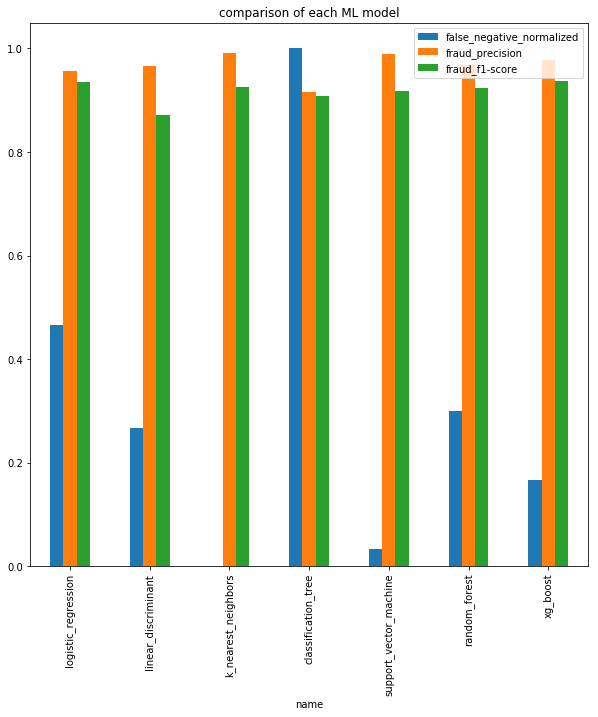

In [111]:
model_viz = blah[['false_negative_normalized', 'fraud_precision', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

# Helpful Articles

- Kaggle Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3
- Useful for understanding SMOTE and why we need to oversample on imbalanced datasets: https://towardsdatascience.com/detecting-financial-fraud-using-machine-learning-three-ways-of-winning-the-war-against-imbalanced-a03f8815cce9 
- walkthrough of same dataset and analysis of different models: https://towardsdatascience.com/detecting-credit-card-fraud-using-machine-learning-a3d83423d3b8
- standardization vs normalization: https://wikidiff.com/standardization/normalization
- AUCROC vs AUPRC: https://stats.stackexchange.com/questions/338826/auprc-vs-auc-roc
- how to build logistic regression: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- using pandas to create training sets for models: https://www.ritchieng.com/pandas-scikit-learn/
- SVM in pandas: http://benalexkeen.com/support-vector-classifiers-in-python-using-scikit-learn/
- Getting XGBoost to work: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
- understanding ML evaluation metrics https://medium.com/x8-the-ai-community/understanding-ml-evaluation-metrics-precision-recall-2b3fb915b666